In [1]:
import serial as ser
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib notebook


def read_arduino(ser,inputBufferSize):
#    data = ser.readline(inputBufferSize)
    data = ser.read(inputBufferSize)
    out =[(int(data[i])) for i in range(0,len(data))]
    return out

def process_data(data):
    data_in = np.array(data)
    result = []
    i = 1
    while i < len(data_in)-1:
        if data_in[i] > 127:
            # Found beginning of frame
            # Extract one sample from 2 bytes
            intout = (np.bitwise_and(data_in[i],127))*128
            i = i + 1
            intout = intout + data_in[i]
            result = np.append(result,intout)
        i=i+1
    return result

In [2]:
# use this to find ports
from serial.tools import list_ports

ports = list_ports.comports()
for port in ports:
    print(port)

/dev/cu.Bluetooth-Incoming-Port - n/a
/dev/cu.mifo_O7R-GAIA - n/a
/dev/cu.mifo_O7L-GAIA - n/a
/dev/cu.usbserial-DJ00DVYG - FT231X USB UART - FT231X USB UART


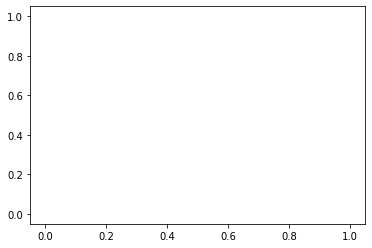

In [3]:
# Read example data
baudrate = 230400
cport = '/dev/cu.usbserial-DJ00DVYG'  # set the correct port before you run it
ser = ser.Serial(port=cport, baudrate=baudrate)    
# take example data
inputBufferSize = 10000 # 20000 = 1 second
ser.timeout = inputBufferSize/20000.0  # set read timeout
#ser.set_buffer_size(rx_size = inputBufferSize)
data = read_arduino(ser,inputBufferSize)
data_plot = process_data(data)
plt.figure()
plt.plot(data_plot)
plt.show()
 

<IPython.core.display.Javascript object>


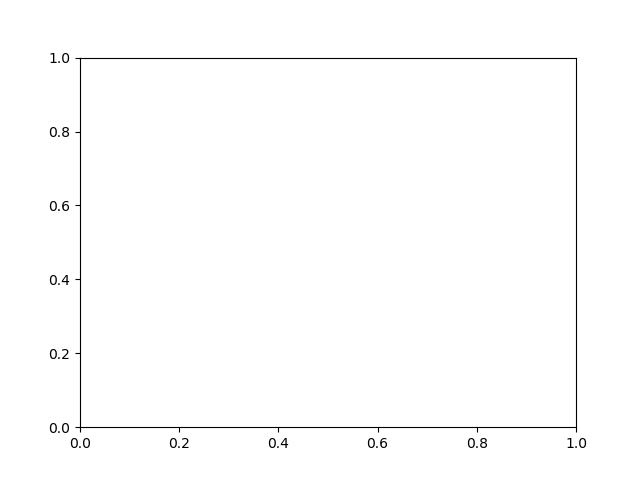

AttributeError: 'list' object has no attribute 'size'

In [4]:
# take continuous data stream 
inputBufferSize = 20002 # keep betweein 2000-20000
ser.timeout = inputBufferSize/20000.0  # set read timeout, 20000 is one second
#this is the problem line on the mac
# ser.set_buffer_size(rx_size = inputBufferSize)

%matplotlib notebook

total_time = 60.0; # time in seconds [[1 s = 20000 buffer size]]
max_time = 10.0; # time plotted in window [s]
N_loops = 20000.0/inputBufferSize*total_time

T_acquire = inputBufferSize/20000.0    # length of time that data is acquired for 
N_max_loops = max_time/T_acquire    # total number of loops to cover desire time window

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
plt.ion()
fig.show()
fig.canvas.draw()
i = 0
last_seq = np.empty(0)

def LR_detection(seq):
    diff = np.max(seq) - np.min(seq)
    maxval = np.argmax(seq)
    minval = np.argmin(seq)
    if diff > 150:
        if maxval < minval:
            return 'L'
        else:
            return 'R'
    else:
        return 'NA'
previous = 'NA'
count = 0

for k in range(0,int(N_loops)):
    data = read_arduino(ser,inputBufferSize)
    data_temp = process_data(data)
    #print(len(data_temp))
    #print(type(data_temp))
    #print(i)
    #print()
    i += 1
    
    combined = np.concatenate((last_seq, data_temp), axis=None)
    combined = np.flip(combined)
    j = 0
    if len(combined) == 20000:
        while j <= 10000:
            interval = combined[j:(j+10000)]
            predicted = LR_detection(interval)
            count += 1
            if previous == 'NA' and (predicted == 'L' or predicted == 'R'):
                if count > 10:
                    print(predicted)
                    count = 0
            j += 1000
    
    last_seq = data_temp
    
    if k <= N_max_loops:
        if k==0:
            data_plot = data_temp
        else:
            data_plot = np.append(data_temp,data_plot)
        t = (min(k+1,N_max_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot).size)
    else:
        data_plot = np.roll(data_plot,len(data_temp))
        data_plot[0:len(data_temp)] = data_temp
    t = (min(k+1,N_max_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot).size)

#    plt.xlim([0,max_time])
    ax1.clear()
    ax1.set_xlim(0, max_time)
    plt.xlabel('time [s]')
    ax1.plot(t,data_plot)
    fig.canvas.draw()
    plt.show()

In [23]:
with open('out.txt', 'w') as f:
    f.writelines(str(i)+'\n' for i in data_plot)